<a href="https://colab.research.google.com/github/tomkart/traffic_cam_nsw/blob/main/Traffic_Cameras_NSW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Pillow

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from PIL import Image
import io
import numpy as np # Import numpy for array operations
import math # Import math for ceiling function
import os


In [11]:
# prompt: read the API_KEY from colab properties file

# Replace 'your_colab_properties_file.txt' with the actual file name
properties_file = '/content/nsw_api_colab_properties_file.txt'

try:
    with open(properties_file, 'r') as f:
        for line in f:
            if line.startswith('API_KEY='):
                API_KEY = line.split('=')[1].strip()
                break  # Exit the loop once the key is found
        else:  # Execute if the loop completes without finding the key
            API_KEY = None
            print("API_KEY not found in the properties file.")

except FileNotFoundError:
    API_KEY = None
    print(f"Error: File '{properties_file}' not found.")

# Now you can use the API_KEY variable
if API_KEY:
  print("API Key found successfully")
  # print("API Key:", API_KEY)

  # Example usage (replace with your actual API call)
  # headers = {'Authorization': f'Bearer {API_KEY}'}
  # response = requests.get('your_api_endpoint', headers=headers)


API Key found successfully


In [12]:
# API endpoint and headers
API_URL = "https://api.transport.nsw.gov.au/v1/live/cameras"

# Updated headers to mimic Safari browser
image_url_headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "image/avif,image/webp,image/apng,image/*,*/*;q=0.8",
    "Referer": "https://webcams.transport.nsw.gov.au/",
}

headers = {
    "accept": "application/json",
    "Authorization": f"apikey {API_KEY}"
}

# Fetch the live camera data
def get_traffic_camera_data():
    response = requests.get(API_URL, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Parse and display the traffic camera data
def display_camera_data(data):
    cameras = data.get("features", [])

    if not cameras:
        print("No camera data available.")
        return

    camera_list = []
    for camera in cameras:
        properties = camera["properties"]
        coordinates = camera["geometry"]["coordinates"]
        camera_list.append({
            "Title": properties.get("title", "N/A"),
            "Image URL": properties.get("href", "N/A"),
            "Latitude": coordinates[1],
            "Longitude": coordinates[0],
            "View": properties.get("direction", "Unknown")
        })

    df = pd.DataFrame(camera_list)
    display(HTML(df.to_html()))
    return df

def show_camera_images(df, num_images=5, images_per_row=4):
    """
    Displays traffic camera images in a grid.

    Args:
        df (pd.DataFrame): DataFrame containing camera data.
        num_images (int, optional): Maximum number of images to display. Defaults to 5.
        images_per_row (int, optional): Number of images to display per row. Defaults to 4.
    """
    num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 5 * num_rows))  # Create subplots

    # Flatten axes if num_rows or images_per_row is 1 for compatibility
    if num_rows == 1 or images_per_row == 1:
        axes = axes.flatten()
    else:
        axes = axes.ravel() #making it a 1D array to easy access

    for i in range(num_images):
        if i >= len(df):
            break
        img_url = df.iloc[i]["Image URL"]
        title = df.iloc[i]["Title"]

        # Open the URL using Pillow and convert to numpy array
        response = requests.get(img_url, headers=image_url_headers)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Error loading image from {img_url}: Status code {response.status_code}")
            continue  # Skip to the next image

        # Check content type to see if is an image
        content_type = response.headers.get('content-type')
        if 'image' not in content_type:
            print(f"URL {img_url} does not appear to be an image. Content-Type: {content_type}")
            continue

        try:
            response.raw.decode_content = True  # Ensure correct decoding
            img = Image.open(io.BytesIO(response.content))
            img = np.array(img)  # Convert PIL Image to NumPy array
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(title, fontsize=10)
        except (PIL.UnidentifiedImageError, OSError) as e:
            print(f"Error loading or decoding image from {img_url}: {e}")
            continue

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()


In [13]:
# Fetch and display camera data
camera_data = get_traffic_camera_data()

camera_df = display_camera_data(camera_data)


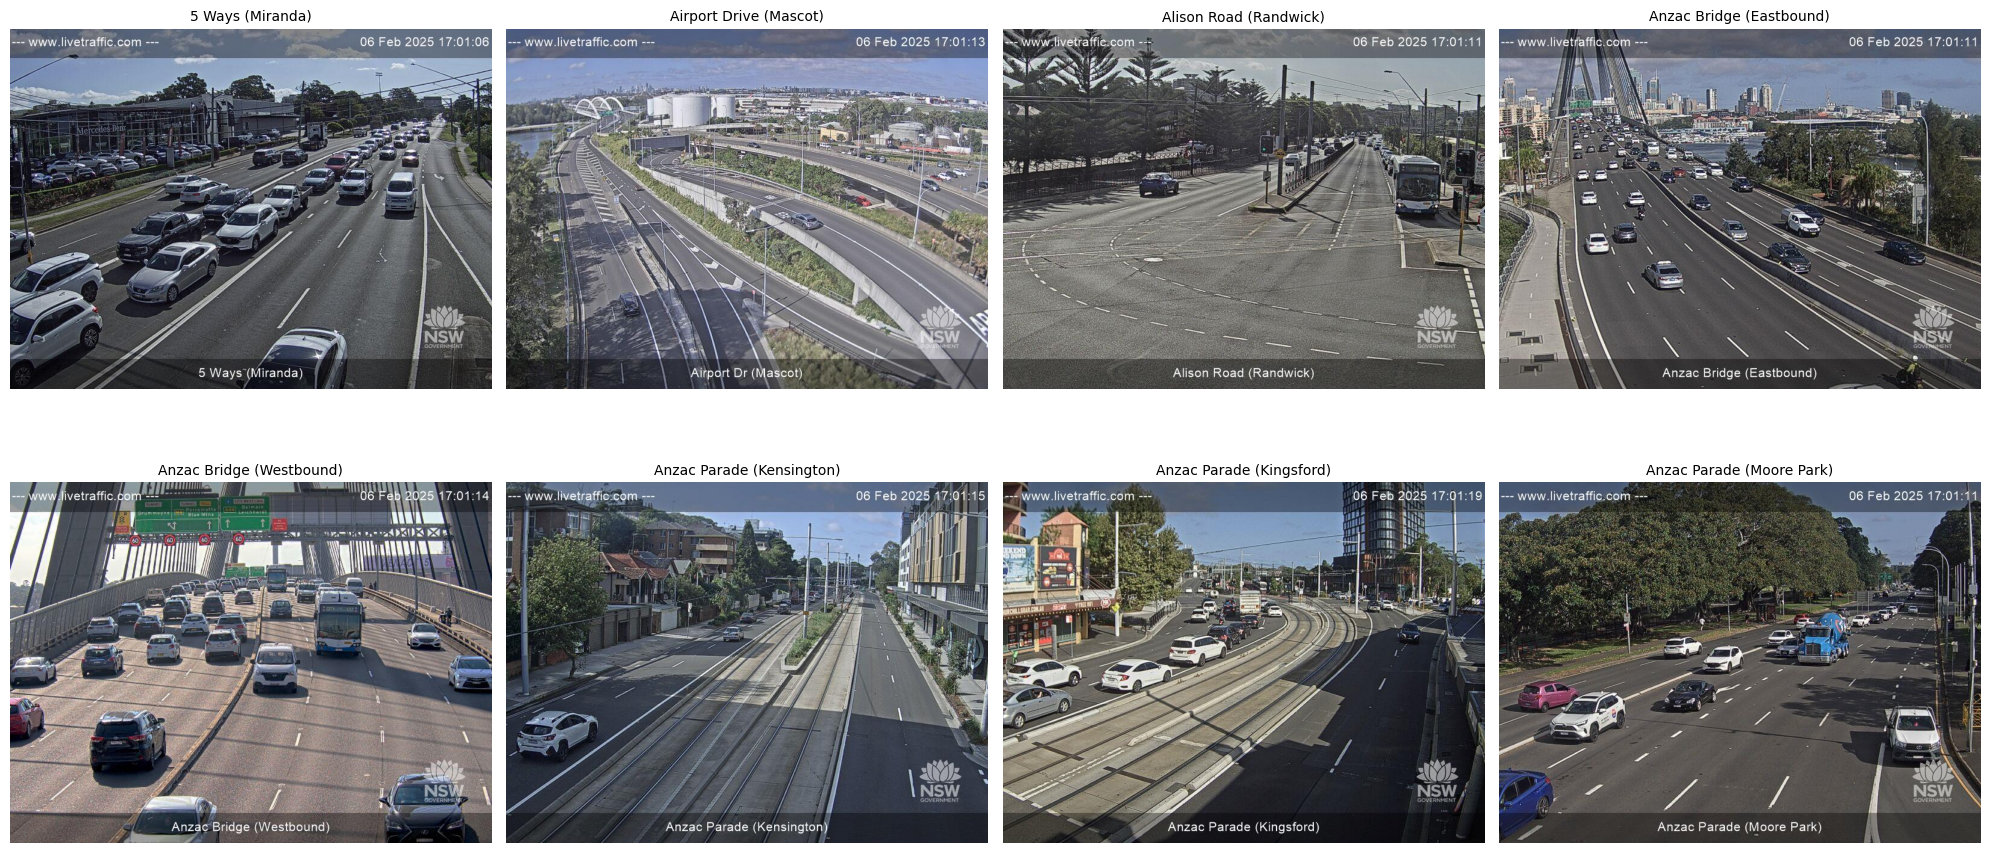

In [14]:

show_camera_images(camera_df, num_images = 8)

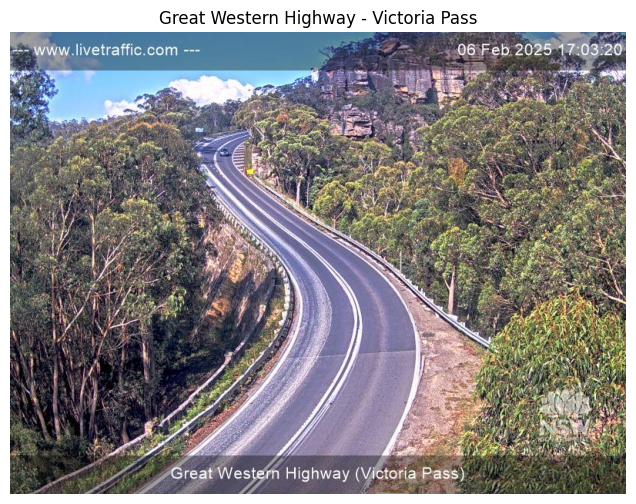

In [17]:
#testing with single image

# URL of the traffic camera image
image_url = "https://webcams.transport.nsw.gov.au/livetraffic-webcams/cameras/great_western_highway_victoria_pass.jpeg"

# Updated headers to mimic Safari browser
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "image/avif,image/webp,image/apng,image/*,*/*;q=0.8",
    "Referer": "https://webcams.transport.nsw.gov.au/",
}

# Fetch and display the image
try:
    response = requests.get(image_url, headers=headers)
    response.raise_for_status()  # Raise an error for unsuccessful requests

    # Open the image
    response.raw.decode_content = True  # Ensure correct decoding
    img = Image.open(io.BytesIO(response.content))
    img = np.array(img)  # Convert PIL Image to NumPy array

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Great Western Highway - Victoria Pass")
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Failed to fetch image: {e}")
